In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import random
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

math = pd.read_csv('stud_math.csv')

In [2]:
def unique_nan_value(name):
    '''Функция показывает все значения в колонке, а так же уникальные и пустые'''
    uniq = math[name].nunique()
    empty = math[name].isnull().sum()
    values = math[name].value_counts()
    print(f'Значения в колонке: Уникальные: {uniq}, Пустые: {empty}. \n{values}' )
    

def nan_to_probably_value(string, name):
    '''Функция заменяет пустые значения на наиболее вероятные'''
    high_res = math[name].value_counts()[0]
    low_res = math[name].value_counts()[1]
    probability = random.randint(0,100)
    percent = round((high_res / (high_res + low_res))*100)
    if pd.isnull(string) == True:
        if probability <= percent:
            return math[name].value_counts().index[0]
        else:
            return math[name].value_counts().index[1]
    else:
        return string     


def replace_nan_to_other(string):
    '''Функция заменяет пустое значение на other'''
    if pd.isnull(string) == True:
        return 'other'
    else:
        return string

    
def replace_nan_to_mean(string, name):
    '''Функция заменяет пустое значение на округленное среднее'''
    mean = round(math[name].mean())
    if pd.isnull(string) == True:
        return mean
    else:
        return string
    
    
def delete_strange_value_in_Fedu(value):
    '''Функция заменяет некорректное значение ввода в колонке 'Fedu' на корректное'''
    if value == float(40):
        return float(4)
    else:
        return value


def delete_strange_value_in_famrel(value):
    '''Функция заменяет некорректное значение ввода в колонке 'famrel' на корректное'''
    if value == float(-1):
        return float(1)
    else:
        return value
    
    
def delete_outliers(name):
    '''Функция используют межквартильный размах для удаления выбросов'''  
    perc_25 = math[name].quantile(0.25)
    perc_75 = math[name].quantile(0.75)
    iqr = perc_75 - perc_25
    lower_border = perc_25 - 1.5*iqr
    upper_border = perc_75 + 1.5*iqr
    return lower_border, upper_border


def boxplot(column):
    '''Функция рисует боксплот'''
    sns.boxplot(x=column, y='score', data=math)

    
def get_stat_dif(column):
    '''Функция проводит тест Стьюдента'''
    cols = math.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(math.loc[math.loc[:, column] == comb[0], 'score'], 
                        math.loc[math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break    

## Цели и задачи
- Провести EDA и отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

## Проведем первичный анализ данных

In [3]:
math.info() # Посмотрим на наш датасет, определим типы колонок и какие данные в них находятся

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Итого у нас 30 колонок, 13 из которых числовые и 17 строковые

In [4]:
math.isnull().sum() # Посмотрим сколько пустых значений в каждой колонке

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

У нас имеется только 3 колонки без пустых значений, следовательно, для всех остальных нужно будет решить, что делать с этими пустыми значениями. Для числовых без выбросов - следует заменить на округленное среднее, а если есть выбросы, то лучше от них избавиться, либо использовать моду или медиану. Для строковых - либо заменить на 'unknown', либо на значения, которые больше всего подходят.

In [5]:
math.nunique() # Посмотрим, сколько уникальных значений имеется в каждой колонке

school                  2
sex                     2
age                     8
address                 2
famsize                 2
Pstatus                 2
Medu                    5
Fedu                    6
Mjob                    5
Fjob                    5
reason                  4
guardian                3
traveltime              4
studytime               4
failures                4
schoolsup               2
famsup                  2
paid                    2
activities              2
nursery                 2
studytime, granular     4
higher                  2
internet                2
romantic                2
famrel                  6
freetime                5
goout                   5
health                  5
absences               36
score                  18
dtype: int64

Больше всего уникальных значений находится в колонках absences (пропущенные занятия) и score (финальная оценка за экзамен). Так как это числовые колонки, возможно в них присутствуют потенциальные выбросы

## Рассмотрим каждую колонку отдельно

Начнем с колонки score, так как она будет использоваться в дальнейшем

Значения в колонке: Уникальные: 18, Пустые: 6. 
50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64


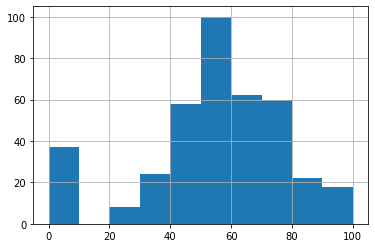

In [6]:
math['score'].hist() #  баллы по госэкзамену по математике
unique_nan_value('score')

По графику видно, что значения распределены нормально, но есть подозрение на выбросы в значении 0. Но также мы можем предположить, что студент либо не получил баллы за экзамен, так как ничего не решил, либо 0 ставится по причине пропуска экзамена, но также у нас есть пустые значения, здесь они могут расцениваться, как отсутствие на экзамене, либо как отсутствие данных. Все равно проверим по формуле, является ли 0 выбросом. Затем будем принимать решение

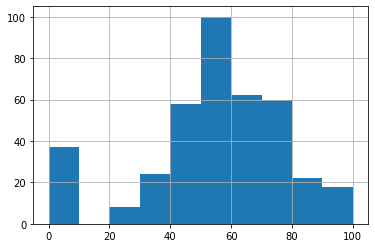

In [7]:
border = delete_outliers('score')
math['score'][math['score'].between(border[0], border[1])].hist() 

Преобразованная гистограмма показывает, что значение 0 не является выбросом. Тогда мы можем построить 2 графика, и сравнить их. В одном предположим, что 0 баллов ставится за нерешенный экзамен, а пустые значения - это отсутствие на экзамене. Во втором случае наоборот предположим, что 0 баллов - это отсутствие на экзамене, а пустые значения заменим на средний балл.

In [8]:
# Вариант 1: 0 баллов - нерешенный экзамен, пустое значение - отсутсвие на экзамене.
border = delete_outliers('score')
math['score_v1'] = math['score'][math['score'].between(border[0], border[1])]
# Вариант 2: 0 баллов - отсутвие на экзамене => не учитываем эти значения, пустое значение - заменяем на среднее
math['score_v2'] = math['score'][math['score'].between(1,100)]
math['score_v2'] = math['score_v2'].apply(replace_nan_to_mean, args=('score_v2',))
math['score_v2'].isnull().sum()

0

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score_v1, dtype: float64

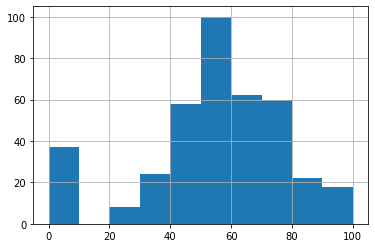

In [9]:
math['score_v1'].hist() 
math['score_v1'].describe() 

- График имеет отрицательное смещение (влево)
- Выбросов нет
- Студенты в среднем сдают экзамен на 52 балла, 37 человек сдали экзамен на 0, 6 человек не явилось на экзамен

count    395.000000
mean      57.782278
std       15.291522
min       20.000000
25%       50.000000
50%       58.000000
75%       70.000000
max      100.000000
Name: score_v2, dtype: float64

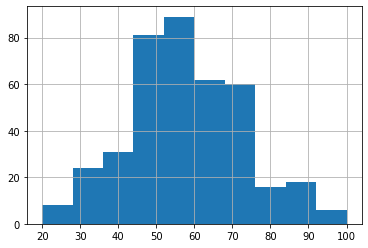

In [10]:
math['score_v2'].hist() 
math['score_v2'].describe() 

- График имеет нормальное распределение.
- Выбросов нет.
- Студенты в среднем сдают экзамен на 58 баллов, 37 человек не явилось на экзамен

Исходя из данных этих 2ух графиков, я считаю, что в дальнейшем лучше использовать график, где 0 означает именно балл. Маловероятно, что 37 человек пропустили госэкзамен по математике, более вероятно, что они плохо готовились, перенервничали или им просто не повезло. 6 пустых значений будем интерпретировать, как пропуски экзамена (что более вероятно, чем 37). Возможно эти 6 человек болели во время проведения.

In [11]:
math['score'] = math['score_v1']
math.drop(['score_v1'], inplace = True, axis = 1) # удалим ненужные колонки
math.drop(['score_v2'], inplace = True, axis = 1)

In [12]:
unique_nan_value('school') # аббревиатуры школ, в которых учился ученик

Значения в колонке: Уникальные: 2, Пустые: 0. 
GP    349
MS     46
Name: school, dtype: int64


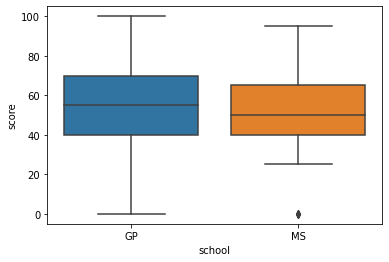

In [13]:
boxplot('school')

In [14]:
unique_nan_value('sex')  # пол студента

Значения в колонке: Уникальные: 2, Пустые: 0. 
F    208
M    187
Name: sex, dtype: int64


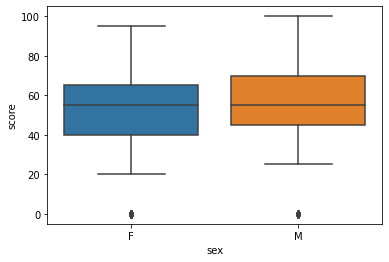

In [15]:
boxplot('sex')

Значения в колонке: Уникальные: 8, Пустые: 0. 
16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64


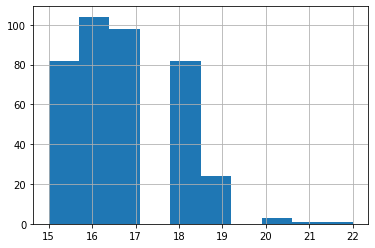

In [16]:
math['age'].hist() # возраст студента
unique_nan_value('age')

По графику видим, что возраст 20-22 возможно является выбросом, поэтому проверим это по формуле Q3 + 1.5*IQR

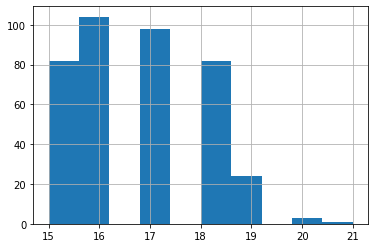

In [17]:
border = delete_outliers('age') # проверим есть ли выбросы
math['age'][math['age'].between(border[0], border[1])].hist() 

- Гистограмма имеет смещение вправо (положительное смещение)
- После преобразования выбросов нет. До преобразования был выброс (22)
- Видно, что большинство студентов младше 19 лет

In [18]:
math['age'] = math['age'][math['age'].between(border[0], border[1])] # Отфильтруем значения в колонке

In [19]:
unique_nan_value('address') # тип адреса ученика ('U' - городской, 'R' - за городом)

Значения в колонке: Уникальные: 2, Пустые: 17. 
U    295
R     83
Name: address, dtype: int64


Большинство студентов живут в городе

В колонке есть пустые значения, их нужно заменить на значение из колонки, либо на 'unknown'.
Посмотрим на пропорцию распределения значений. Значение U попадается в 78% случаев (без учета пустых значений). Мы можем это использовать, чтобы заменить пустые значения в колонке. С большой вероятностью пустые значения распределялись бы точно так же, поэтому мы можем применить функцию, которая заменяет пустые значения на наиболее вероятные в данной колонке.

In [20]:
math['address'] = math['address'].apply(nan_to_probably_value, args=('address',)) # заменим пустые значения на возможное значение
unique_nan_value('address')

Значения в колонке: Уникальные: 2, Пустые: 0. 
U    309
R     86
Name: address, dtype: int64


Конечно, в данном случае можно использовать моду, но, мне кажется, что данный алгоритм более подходящий

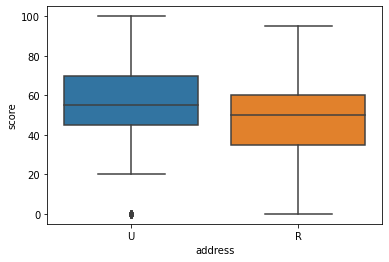

In [21]:
boxplot('address')

In [22]:
unique_nan_value('famsize') # размер семьи('LE3' <= 3, 'GT3' >3)

Значения в колонке: Уникальные: 2, Пустые: 27. 
GT3    261
LE3    107
Name: famsize, dtype: int64


Большинство студентов имеют семью, состоящую из более 3 членов 

Заменим пустые значения тем же способом, что и для предыдущей колонки

In [23]:
math['famsize'] = math['famsize'].apply(nan_to_probably_value, args=('famsize',))
unique_nan_value('famsize')

Значения в колонке: Уникальные: 2, Пустые: 0. 
GT3    283
LE3    112
Name: famsize, dtype: int64


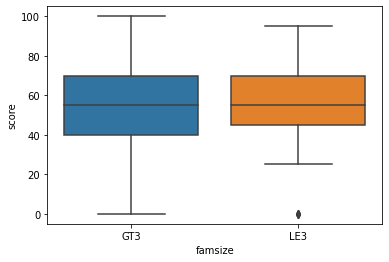

In [24]:
boxplot('famsize')

In [25]:
unique_nan_value('Pstatus') # статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

Значения в колонке: Уникальные: 2, Пустые: 45. 
T    314
A     36
Name: Pstatus, dtype: int64


Большинство студентов живут вместе с родителями

Повторим операцию с заменой

In [26]:
math['Pstatus'] = math['Pstatus'].apply(nan_to_probably_value, args=('Pstatus',))
unique_nan_value('Pstatus')

Значения в колонке: Уникальные: 2, Пустые: 0. 
T    353
A     42
Name: Pstatus, dtype: int64


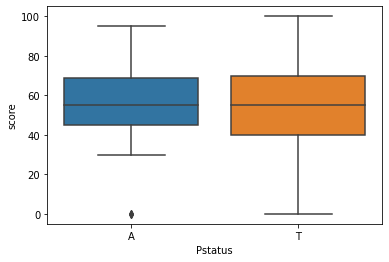

In [27]:
boxplot('Pstatus')

Значения в колонке: Уникальные: 5, Пустые: 3. 
4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64


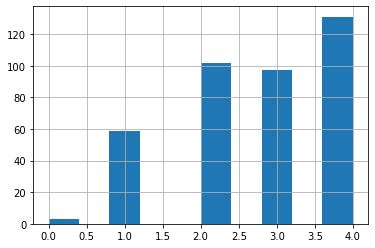

In [28]:
math['Medu'].hist() # образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
unique_nan_value('Medu')

Имеются 3 пустых значения. Возможно будет лучше заменить их на среднее, так как на графике выбросов нет

In [29]:
math['Medu'] = math['Medu'].apply(replace_nan_to_mean, args=('Medu',))
math['Medu'].isnull().sum()

0

count    395.000000
mean       2.751899
std        1.094154
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

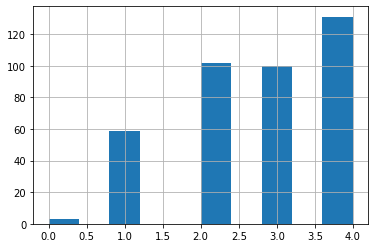

In [30]:
math['Medu'].hist() 
math['Medu'].describe() 

Гистограмма после преобразований:
- График имеет тенденцию на рост
- Выбросов нет 
- Cамая большая группа студентов те, у которых мать имеет высшее образование. Возможно это будет связано с результатами студентов


Значения в колонке: Уникальные: 6, Пустые: 24. 
2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64


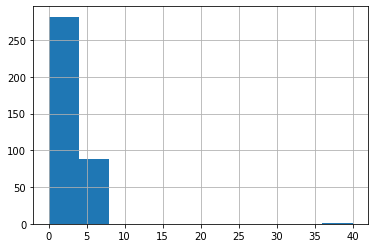

In [31]:
math['Fedu'].hist() # образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
unique_nan_value('Fedu')

На графике виден 1 выброс (40). Скорее всего это ошибка в вводе данных, поэтому ее стоит заменить на 4

In [32]:
math['Fedu'] = math['Fedu'].apply(delete_strange_value_in_Fedu)

24 пустых значения. Их тоже лучше заменить на среднее, так как от выброса мы избавились

In [33]:
math['Fedu'] = math['Fedu'].apply(replace_nan_to_mean, args=('Fedu',))
math['Fedu'].isnull().sum()

0

Построим гистограмму для обновленной колонки

count    395.000000
mean       2.546835
std        1.061418
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

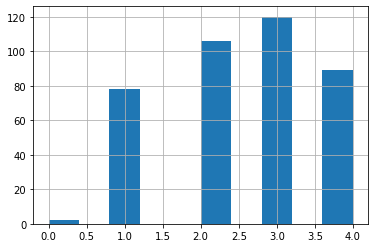

In [34]:
math['Fedu'].hist()
math['Fedu'].describe()

- Гистограмма имеет смещение влево (отрицательное смещение)
- Выбросов нет
- Самая большая группа студентов у которых отец имеет средне-специальное образование или 11 классов. 

In [35]:
unique_nan_value('Mjob') # работа матери

Значения в колонке: Уникальные: 5, Пустые: 19. 
other       133
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64


Пустые значения здесь лучше всего заменить на 'other'

In [36]:
math['Mjob'] = math['Mjob'].apply(replace_nan_to_other)
math['Mjob'].isnull().sum()

0

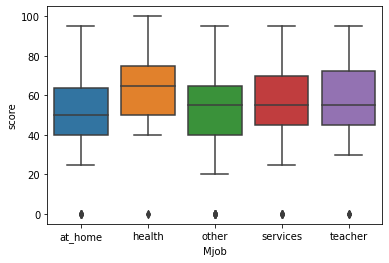

In [37]:
boxplot('Mjob')

На графике видно, что студенты, у которых мать работает в сфере здравоохранения, в среднем сдают экзамен лучше всех остальных, возможно это стоит учесть в дальнейшей модели. Это будет понятно после теста Стьюдента.

Проделаем все то же самое для колонки с работой отца

In [38]:
unique_nan_value('Fjob') # работа отца

Значения в колонке: Уникальные: 5, Пустые: 36. 
other       197
services    102
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64


 Заменим пустые на 'other'

In [39]:
math['Fjob'] = math['Fjob'].apply(replace_nan_to_other)
math['Fjob'].isnull().sum()

0

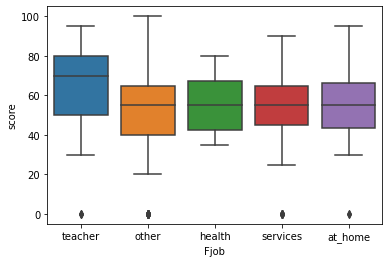

In [40]:
boxplot('Fjob')

На этом графике так же видно, что в среднем студенты, у которых отец учитель, сдают экзамен лучше других

In [41]:
unique_nan_value('reason') # причина выбора школы 

Значения в колонке: Уникальные: 4, Пустые: 17. 
course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64


Заменим пустые значения на other

In [42]:
math['reason'] = math['reason'].apply(replace_nan_to_other)
math['reason'].isnull().sum()

0

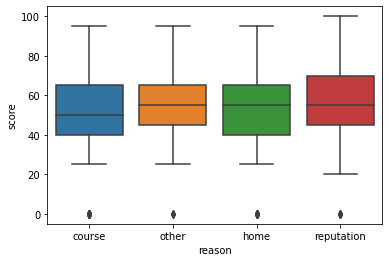

In [43]:
boxplot('reason')

In [44]:
unique_nan_value('guardian') # опекун студента

Значения в колонке: Уникальные: 3, Пустые: 31. 
mother    250
father     86
other      28
Name: guardian, dtype: int64


Заменим пустые значения на other

In [45]:
math['guardian'] = math['guardian'].apply(replace_nan_to_other)
math['guardian'].isnull().sum()

0

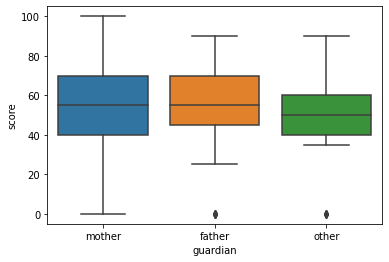

In [46]:
boxplot('guardian')

Значения в колонке: Уникальные: 4, Пустые: 28. 
1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64


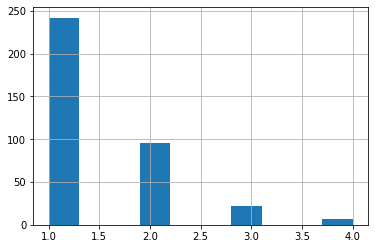

In [47]:
math['traveltime'].hist() # время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
unique_nan_value('traveltime')

28 пустых значений. Заменим их на среднее

In [48]:
math['traveltime'] = math['traveltime'].apply(replace_nan_to_mean, args=('traveltime',))
math['traveltime'].isnull().sum()

0

count    395.000000
mean       1.407595
std        0.678490
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

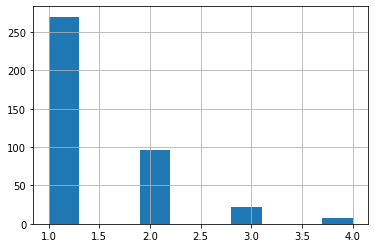

In [49]:
math['traveltime'].hist() 
math['traveltime'].describe() 

- Гистограмма имеет тенденцию на снижение
- Выбросов нет
- Большинство студентов живут вблизи школы

Значения в колонке: Уникальные: 4, Пустые: 7. 
2.0    194
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64


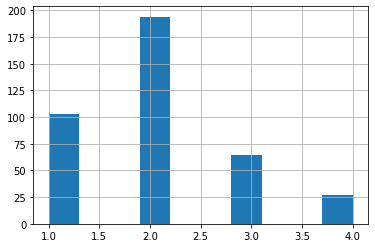

In [50]:
math['studytime'].hist() #  время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
unique_nan_value('studytime')

7 пустых значений, так же заменим их на среднее

In [51]:
math['studytime'] = math['studytime'].apply(replace_nan_to_mean, args=('studytime',))
math['studytime'].isnull().sum()

0

count    395.000000
mean       2.037975
std        0.834580
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

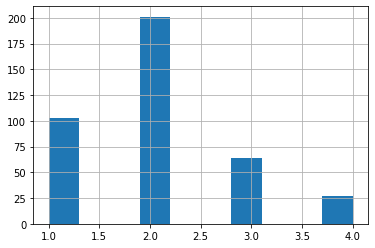

In [52]:
math['studytime'].hist() 
math['studytime'].describe() 

- Гистограмма имеет смещение вправо (положительное смещение)
- Выбросов нет
- В среднем ученики тратят по 2-5 часов на дополнительное обучение, меньше всего учеников тратят больше 5 часов.

Значения в колонке: Уникальные: 4, Пустые: 22. 
0.0    293
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64


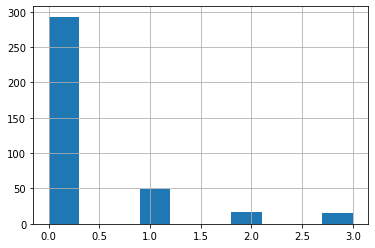

In [53]:
math['failures'].hist() # количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
unique_nan_value('failures')

22 пустых значения. Повторим операцию

In [54]:
math['failures'] = math['failures'].apply(replace_nan_to_mean, args=('failures',))
math['failures'].isnull().sum()

0

count    395.000000
mean       0.318987
std        0.726244
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

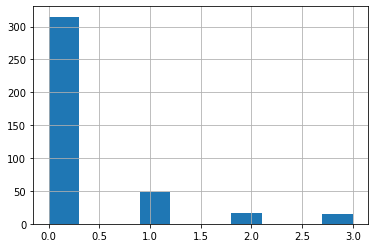

In [55]:
math['failures'].hist() 
math['failures'].describe() 

- Гистограмма имеет тренд на снижение
- Выбросов нет
- Большинство учеников не имеют внешкольных неудач

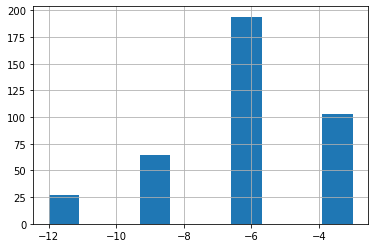

In [56]:
math['studytime, granular'].hist() 

Видно, что график полностью похож на стобец studytime, только с отрицательным смещением. Проверим коррелируют ли они, если да, то лучше удалить этот столбец

In [57]:
round(math['studytime, granular'].corr(math['studytime']),2)

-1.0

Эти 2 столбца коррелируют полностью, но с противоположным знаком, в любом случае лучше удалить этот столбец

In [58]:
math.drop(['studytime, granular'], inplace = True, axis = 1)

In [59]:
unique_nan_value('schoolsup') # дополнительная образовательная поддержка (yes или no)

Значения в колонке: Уникальные: 2, Пустые: 9. 
no     335
yes     51
Name: schoolsup, dtype: int64


9 пустых значений. Заменим пустые значения на возможные

In [60]:
math['schoolsup'] = math['schoolsup'].apply(nan_to_probably_value, args=('schoolsup',))
math['schoolsup'].value_counts()

no     344
yes     51
Name: schoolsup, dtype: int64

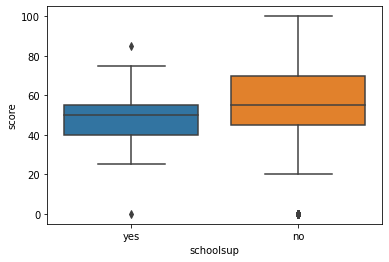

In [61]:
boxplot('schoolsup')

In [62]:
unique_nan_value('famsup') # семейная образовательная поддержка (yes или no)

Значения в колонке: Уникальные: 2, Пустые: 39. 
yes    219
no     137
Name: famsup, dtype: int64


Заменяем пустые значения

In [63]:
math['famsup'] = math['famsup'].apply(nan_to_probably_value, args=('famsup',))
math['famsup'].value_counts()

yes    242
no     153
Name: famsup, dtype: int64

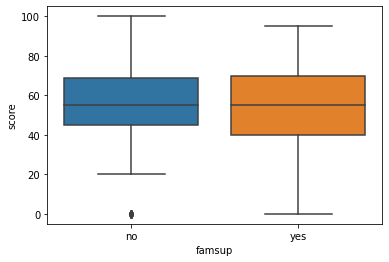

In [64]:
boxplot('famsup')

In [65]:
unique_nan_value('paid') # дополнительные платные занятия по математике (yes или no)

Значения в колонке: Уникальные: 2, Пустые: 40. 
no     200
yes    155
Name: paid, dtype: int64


40 пустых значений. Заменяем их

In [66]:
math['paid'] = math['paid'].apply(nan_to_probably_value, args=('paid',))
math['paid'].value_counts()

no     222
yes    173
Name: paid, dtype: int64

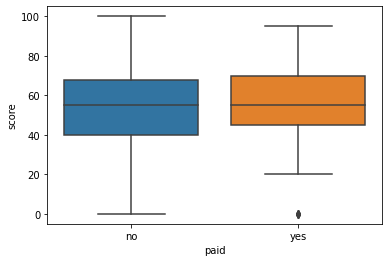

In [67]:
boxplot('paid')

In [68]:
unique_nan_value('activities') # дополнительные внеучебные занятия (yes или no)

Значения в колонке: Уникальные: 2, Пустые: 14. 
yes    195
no     186
Name: activities, dtype: int64


Здесь и ниже буду применять такой же алгоритм замены пустых значений

In [69]:
math['activities'] = math['activities'].apply(nan_to_probably_value, args=('activities',))
math['activities'].value_counts()

yes    203
no     192
Name: activities, dtype: int64

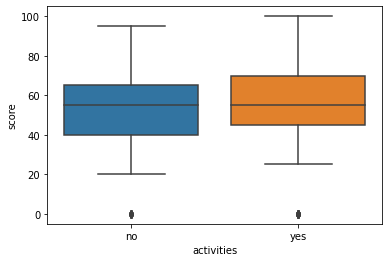

In [70]:
boxplot('activities')

In [71]:
unique_nan_value('nursery') # посещал детский сад (yes или no)

Значения в колонке: Уникальные: 2, Пустые: 16. 
yes    300
no      79
Name: nursery, dtype: int64


In [72]:
math['nursery'] = math['nursery'].apply(nan_to_probably_value, args=('nursery',))
math['nursery'].value_counts()

yes    313
no      82
Name: nursery, dtype: int64

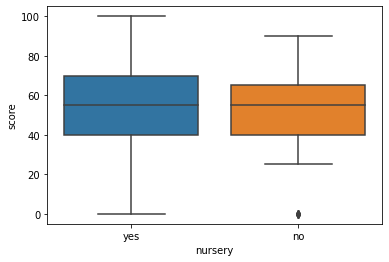

In [73]:
boxplot('nursery')

In [74]:
unique_nan_value('higher') # хочет получить высшее образование (yes или no)

Значения в колонке: Уникальные: 2, Пустые: 20. 
yes    356
no      19
Name: higher, dtype: int64


In [75]:
math['higher'] = math['higher'].apply(nan_to_probably_value, args=('higher',))
math['higher'].value_counts()

yes    376
no      19
Name: higher, dtype: int64

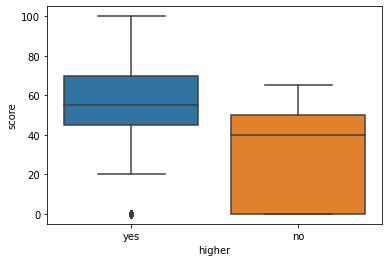

In [76]:
boxplot('higher')

На графике видна явная тендеция, что студенты, которые не планируют получить высшее образование, сдают экзамен хуже, хотя их значительно меньше, чем остальных.

In [77]:
unique_nan_value('internet') # наличие интернета дома (yes или no)

Значения в колонке: Уникальные: 2, Пустые: 34. 
yes    305
no      56
Name: internet, dtype: int64


In [78]:
math['internet'] = math['internet'].apply(nan_to_probably_value, args=('internet',))
math['internet'].value_counts()

yes    335
no      60
Name: internet, dtype: int64

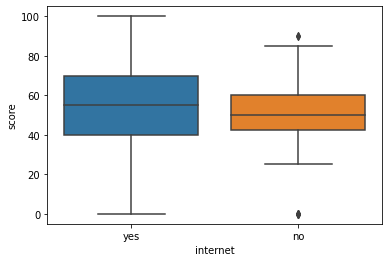

In [79]:
boxplot('internet')

In [80]:
unique_nan_value('romantic') # в романтических отношениях (yes или no)

Значения в колонке: Уникальные: 2, Пустые: 31. 
no     240
yes    124
Name: romantic, dtype: int64


In [81]:
math['romantic'] = math['romantic'].apply(nan_to_probably_value, args=('romantic',))
math['romantic'].value_counts()

no     262
yes    133
Name: romantic, dtype: int64

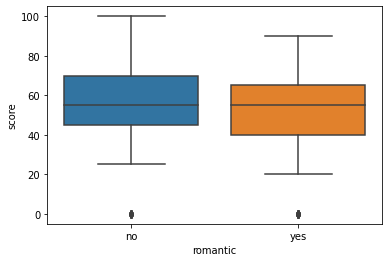

In [82]:
boxplot('romantic')

Значения в колонке: Уникальные: 6, Пустые: 27. 
 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64


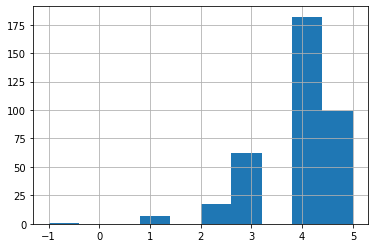

In [83]:
math['famrel'].hist() # семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
unique_nan_value('famrel')

На графике виден выброс, но скорее всего это ошибка ввода, так как это значение -1, предположим, что имелось ввиду значение 1. Нужно удалить этот выброс. Просто заменим -1 на 1

In [84]:
math['famrel'] = math['famrel'].apply(delete_strange_value_in_famrel)
unique_nan_value('famrel')

Значения в колонке: Уникальные: 5, Пустые: 27. 
4.0    182
5.0     99
3.0     62
2.0     17
1.0      8
Name: famrel, dtype: int64


Пустые значения заменяем на среднее, так как выбросов теперь нет

In [85]:
math['famrel'] = math['famrel'].apply(replace_nan_to_mean, args=('famrel',))
math['famrel'].isnull().sum()

0

count    395.000000
mean       3.946835
std        0.872425
min        1.000000
25%        4.000000
50%        4.000000
75%        4.500000
max        5.000000
Name: famrel, dtype: float64

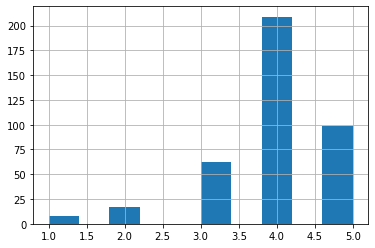

In [86]:
math['famrel'].hist() 
math['famrel'].describe() 

- График имеет отрицательное смещение (смещение влево)
- Выбросов нет
- В большинстве случаев студенты имеют хорошие отношения с родителями.

Значения в колонке: Уникальные: 5, Пустые: 11. 
3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
Name: freetime, dtype: int64


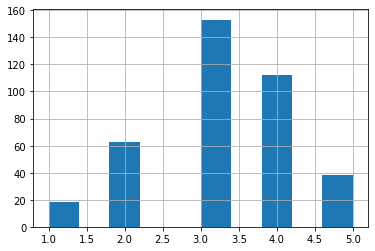

In [87]:
math['freetime'].hist() # свободное время после школы (от 1 - очень мало до 5 - очень много)
unique_nan_value('freetime')

Выбросов нет, заменяем пустые значения.

In [88]:
math['freetime'] = math['freetime'].apply(replace_nan_to_mean, args=('freetime',))
math['freetime'].isnull().sum()

0

count    395.000000
mean       3.225316
std        0.980711
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

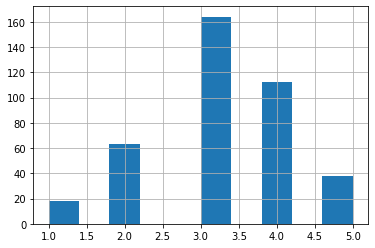

In [89]:
math['freetime'].hist() 
math['freetime'].describe() 

- График имеет нормальное распределение
- Выбросов нет
- У студентов среднее кол-во свободного времени

Значения в колонке: Уникальные: 5, Пустые: 8. 
3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Name: goout, dtype: int64


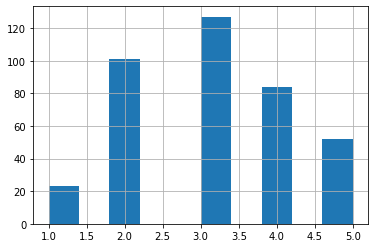

In [90]:
math['goout'].hist() # проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
unique_nan_value('goout')

Выбросов нет. Делаем замену

In [91]:
math['goout'] = math['goout'].apply(replace_nan_to_mean, args=('goout',))
math['goout'].isnull().sum()

0

count    395.000000
mean       3.103797
std        1.104610
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

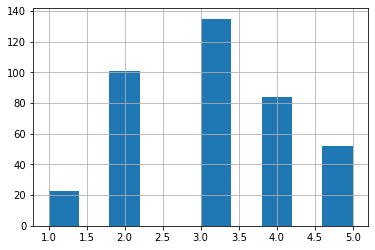

In [92]:
math['goout'].hist() 
math['goout'].describe() 

- График имеет нормальное распределение
- Выбросов нет
- Студенты проводят с друзьями среднее кол-во времени

Значения в колонке: Уникальные: 5, Пустые: 15. 
5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
Name: health, dtype: int64


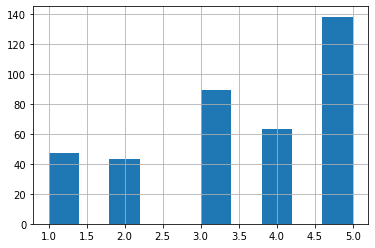

In [93]:
math['health'].hist() # текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
unique_nan_value('health')

Без выбросов. Производим замену пустых значений 

In [94]:
math['health'] = math['health'].apply(replace_nan_to_mean, args=('health',))
math['health'].isnull().sum()

0

count    395.000000
mean       3.549367
std        1.372118
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

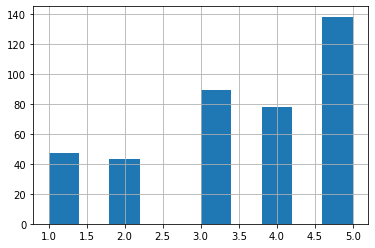

In [95]:
math['health'].hist() 
math['health'].describe() 

- График имеет тендецию роста
- Выбросов нет
- Студенты в основном имеют хорошее или отличное здоровье

Значения в колонке: Уникальные: 36, Пустые: 12. 
0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64


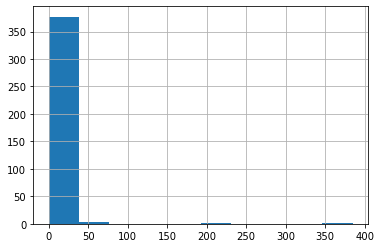

In [96]:
math['absences'].hist() # количество пропущенных занятий
unique_nan_value('absences')

По графику видим,что есть выбросы (212,385). Избавимся от них, используем межквартильный размах и квартили. После этого произведем замену пустых значений на среднее.

In [97]:
border = delete_outliers('absences')
math['absences'] = math['absences'][math['absences'].between(border[0], border[1])]
math['absences'] = math['absences'].apply(replace_nan_to_mean, args=('absences',))
math['absences'].isnull().sum()

0

count    395.000000
mean       4.632911
std        4.780399
min        0.000000
25%        0.000000
50%        4.000000
75%        6.000000
max       20.000000
Name: absences, dtype: float64

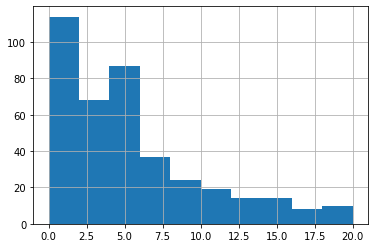

In [98]:
math['absences'].hist() 
math['absences'].describe() 

- График имеет тендецию снижения
- После преобразования выбросов нет. До преобразования были 2 выброса (212, 385)
- Студенты в большинстве случаев имееют 5 пропусков и меньше

## Проведем корреляционный анализ количественных переменных

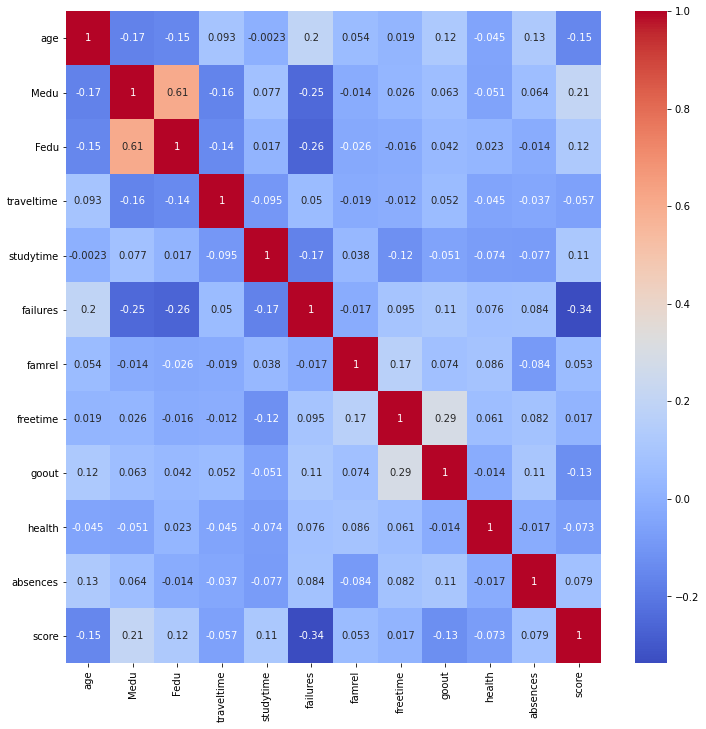

In [99]:
sns.heatmap(math.corr(), annot=True, cmap='coolwarm')
plt.gcf().set_size_inches(12, 12)

- По графику корреляции можно заметить, что столбцы Medu и Fedu скоррелированны на 0,6. Но, я считаю, что их лучше оставить, потому что эти 2 значения влияют на score по-разному. 
- Отметим, что все значения слабоскоррелированны с финальной оценкой за экзамен, но некоторые скоррелированны немного больше остальных - это возраст, образование родителей, время на учебу, неудачи, проведенное время с друзьями. (возможно только их и следует оставить для модели)
- Так же отметим, что положительная корреляция образования родителей и затраченного учебного времени помимо школы может говорить о том, что эти факторы могут положительно влиять на результат студента.
- Отрицательная корреляция со столбцом кол-ва неудач, возраста студента и проведенного с друзьями времени, может означать, что  эти факторы влияют отрицательно на итоговый результат.

## Проведем анализ номинативных переменных

In [100]:
for column in ['school', 'sex', 'address', 'Mjob', 'Fjob','famsize', 'Pstatus', 'reason', 'guardian', 'schoolsup',
              'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(column)

Найдены статистически значимые различия для колонки Mjob


- Проведя тест Стьюдента, видим, что единственные статистически значимые различия существуют только для колонки Mjob (работа матери). Эту колонку точно берем для модели
- Анализируя графики (боксплоты) колонок, можно предположить, что колонки Fjob (работа отца) и higher (хочет ли студент получить высшее образование) так же важны для модели, но тест стьюдента не показал этого. (возможно их стоит включить в модель)

## Финальные выводы

- В данных наблюдалось достаточно много пустых значений, которые удалось успешно заменить на наиболее подходящие.
- Выбросы были найдены только в 4 столбцах. В 2 из них это были скорее всего ошибки ввода, которые были устранены. В оставшихся столбцах мы воспользовались формулами, позволяющими оценить эти выбросы. Затем все выбросы были удалены.
- Положительная корреляция некоторых столбцов (Medu, Fedu, studytime) и финальной оценки, может говорить о том, что эти факторы могут положительно влиять на результат.
- Отрицательная корреляция некоторых столбцов (age, failures, goout) и финальной оценки, может говорить о том, что эти факторы возможно отрицательно влияют на итоговый результат.
- Самые важные параметры, которые стоит использовать для дальнейшей модели: age, Medu, Fedu, studytime, failures, goout, Mjob.
- Возможно, стоит обратить внимание на эти параметры, они так же могут оказаться важны: traveltime, freetime, famrel, health, absences, Fjob, higher.